In [1]:
# Install required libs
#!pip install -U segmentation-models-pytorch albumentations --user 

In [2]:
#!pip uninstall -y segmentation-models-pytorch

## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision import datasets
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from PIL import Image

In [2]:
x_train_dir = os.path.join('nails/images')
y_train_dir = os.path.join('nails/labels')

x_valid_dir = os.path.join('val/images')
y_valid_dir = os.path.join('val/labels')

x_test_dir = os.path.join('val/images')
y_test_dir = os.path.join('val/labels')

In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [4]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [5]:
import albumentations as A
import torch
import numpy as np
import PIL
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

class NailsDataset(torch.utils.data.Dataset):
  def __init__(self, path_to_imgs, path_to_masks, tr1, tr2):
    self.img_names = sorted([path_to_imgs + filename for filename in os.listdir(path_to_imgs)])
    self.mask_names = sorted([path_to_masks + filename for filename in os.listdir(path_to_masks)])
    self.trans1 = tr1
    self.trans2 = tr2
  
  def __len__(self):
    return len(self.img_names)
  
  def __getitem__(self, index):
    image_path = self.img_names[index]
    mask_path = self.mask_names[index]
    
    img = Image.open(image_path)
    mask = Image.open(mask_path)
    transform_mask = transforms.Compose([transforms.ToTensor(), 
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  								  transforms.Resize((480,480))])
    augmented = self.trans2(image=np.array(img), mask=np.array(mask))
    img = transform_mask(augmented['image'])
    mask = self.trans1(augmented['mask'])
    return img, mask[0].view(1, 480, 480)

transform_1 = transforms.Compose([transforms.ToTensor(),
  								  transforms.Resize((480,480))])

train_transform = A.Compose([
    A.Flip(p=0.5),
    A.RandomBrightnessContrast(p=0.6),
    A.GaussNoise(p=0.2),
    A.OneOf([
      	A.Sharpen(p=1),
    	A.GridDistortion(p=1),
    ], p=0.5),
    A.SafeRotate(limit=(-15,15), p=0.6),
    #A.RandomSizedCrop(min_max_height=(30, 60), size=(320, 320), p=0.5),
  	#A.PadIfNeeded(min_height=320, min_width=320, p=1),
])
val_transform = A.Compose([
	A.Flip(p=0)
])

## Create model and train

In [6]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smp_utils

c:\Users\Александр\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['nails']
ACTIVATION = "sigmoid" # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS,
	in_channels=3,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

nails_ds = NailsDataset('nails/images/', 'nails/labels/', tr1=transform_1, tr2=train_transform)
val_ds = NailsDataset("val/images/", 'val/labels/', tr1=transform_1, tr2=val_transform)

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: 'nails/images/'

In [ ]:
train_loader = DataLoader(nails_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(val_ds, batch_size=4, shuffle=False)

In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index
loss = smp_utils.losses.BCEWithLogitsLoss()
metrics = [
    smp_utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp_utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp_utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [13]:
# train model for 1000 epochs

max_score = 0
train_logs_list = []
valid_logs_list = []
for i in range(0, 1000):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    train_logs_list.append(train_logs)
    valid_logs_list.append(valid_logs)
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
    if i == 10:
        optimizer.param_groups[0]['lr'] = 5e-5
    if i == 500:
        optimizer.param_groups[0]['lr'] = 3e-5
    if i == 800:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.33it/s, bce_with_logits_loss - 0.9376, iou_score - 0.01379]
Model saved!

Epoch: 1
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.83it/s, bce_with_logits_loss - 0.9515, iou_score - 0.02178]
Model saved!

Epoch: 2
valid: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.78it/s, bce_with_logits_loss - 0.9533, iou_score - 0.0292]
Model saved!

Epoch: 3
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.42it/s, bce_with_logits_loss - 0.9487, iou_score - 0.03304]
Model saved!

Epoch: 4
valid: 100%|██████████████████████████████████████

## Test best saved model

In [12]:
# load best saved checkpoint
best_model = torch.load('best_model83.pth')

## Visualize predictions

TypeError: 'JpegImageFile' object is not subscriptable

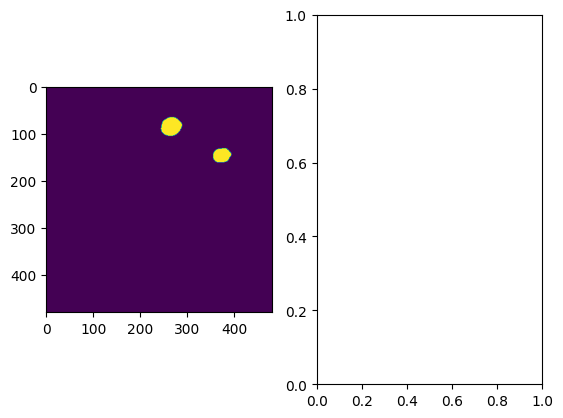

In [15]:
t1 = Image.open("test2.jpg")
transform_mask = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  								  transforms.Resize((480,480))])
t11 = transform_mask(t1)
x_tensor = t11.to(DEVICE).unsqueeze(0)
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())
plt.subplot(1, 2, 1)
plt.imshow(pr_mask)
plt.subplot(1, 2, 2)
plt.imshow(np.array(t1))
#plt.subplot(1, 3, 3)
#plt.imshow(val_ds[i][1][0])
plt.show()

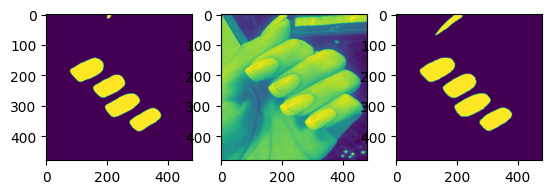

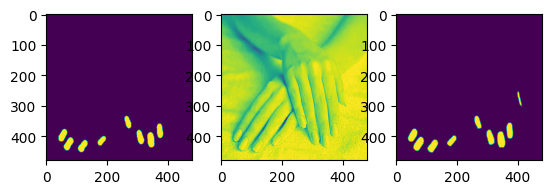

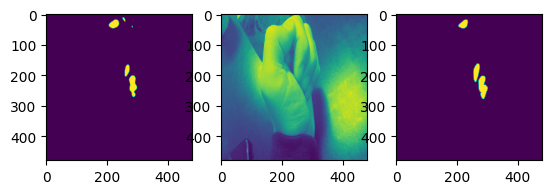

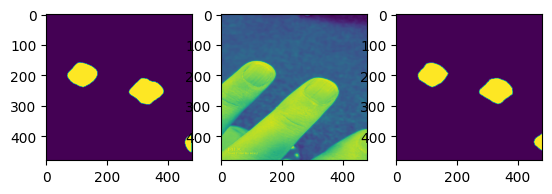

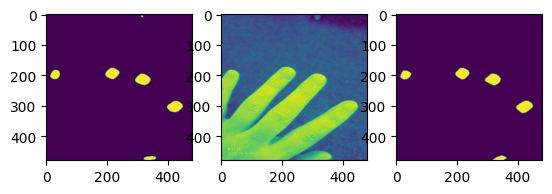

In [20]:
for i in range(5):
	x_tensor = val_ds[i][0].to(DEVICE).unsqueeze(0)
	pr_mask = best_model.predict(x_tensor)
	pr_mask = (pr_mask.squeeze().cpu().numpy().round())
	plt.subplot(1, 3, 1)
	plt.imshow(pr_mask)
	plt.subplot(1, 3, 2)
	plt.imshow(val_ds[i][0][0])
	plt.subplot(1, 3, 3)
	plt.imshow(val_ds[i][1][0])
	plt.show()

{'bce_with_logits_loss': 0.8961244821548462, 'iou_score': 0.051126593723893166}


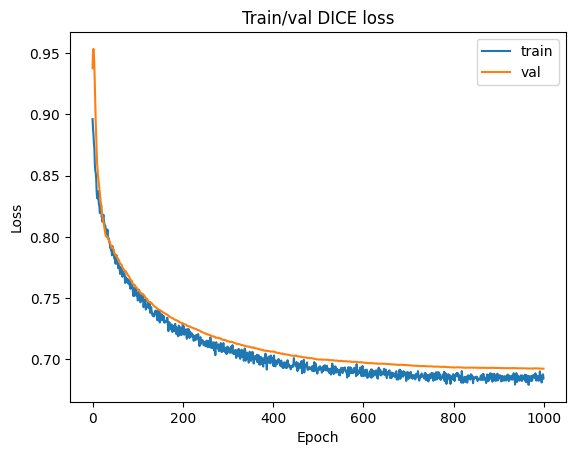

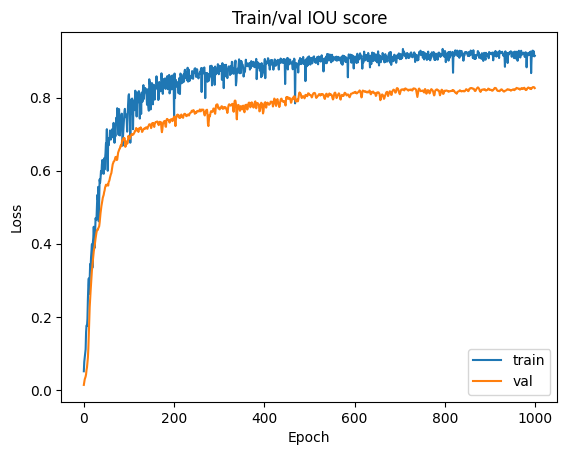

In [17]:
print(train_logs_list[0])
dl_train = [i["bce_with_logits_loss"] for i in train_logs_list]
dl_val = [i["bce_with_logits_loss"] for i in valid_logs_list]
iou_train = [i["iou_score"] for i in train_logs_list]
iou_val = [i["iou_score"] for i in valid_logs_list]
plt.plot(dl_train, label='train')
plt.plot(dl_val, label="val")
plt.legend()
plt.title('Train/val DICE loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(iou_train, label='train')
plt.plot(iou_val, label="val")
plt.legend()
plt.title('Train/val IOU score')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [23]:
test_epoch = smp_utils.train.ValidEpoch(
    best_model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

test_epoch.run(valid_loader)

valid:   0%|          | 0/3 [00:00<?, ?it/s]

valid: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s, bce_with_logits_loss - 0.6924, iou_score - 0.8288]


{'bce_with_logits_loss': 0.6923510233561198, 'iou_score': 0.8287850817044576}

In [24]:
loss = smp_utils.losses.BCEWithLogitsLoss()
metrics = [smp_utils.metrics.Fscore(1)]
test_epoch = smp_utils.train.ValidEpoch(
    best_model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

test_epoch.run(valid_loader)

valid: 100%|██████████| 3/3 [00:00<00:00,  4.22it/s, bce_with_logits_loss - 0.6924, fscore - 0.9063]


{'bce_with_logits_loss': 0.6923510233561198, 'fscore': 0.9062541921933492}